## 1. Quantum Approximation Optimization Algorithm (QAOA)

<b>During my study, I found two excellent references [6,7]</b> to get induced by MaxCut and QAOA in general. Under the section III "III. QUANTUM APPROXIMATE OPTIMIZATION ALGORITHM (QAOA)", subsection A. "The overview of QAOA" in the article from Choi and Kim [6] provides a didactic breakdown for QAOA. Incidentally, the breakdown proves to be crucial possession for destructing the MaxCut problem. Next, the article by Wang and Abdullah [7] provides insightful run over not only the algorithms but the circuits implementations too. <b>I firmly recommend you to read these two references.</b> Finally, the primary reference I used to produce this notebook is a Bachelor's thesis [8]. 

Quantum Approximate Optimization Algorithm (QAOA) is one of the flavor out of a collection termed as Variational Quantum Algorithms (VQA). QAOA is an approximation algorithm, that means it does not deliver the ‘best’ result, but only the ‘good enough’ result. How good of the result is quantified by a lower bound named approximation ratio. It runs on NISQ desvices and are promising candidate for asserting the so-called "Quantum Supremacy" [3]. Farhi, E. et al.[2] introduced the algorithm, in their work they solved the Max-Cut problem. They went ahead to provided the approximation ratio for "3-Regular Graphs".  

Modularity is a glaring presence in VQAs. So it is for QAOA, being an element of it. A variational algorithm comprises several modular components that can be readily combined, extended and improved with developments in quantum hardware and algorithms. The parts are, Objective function, Parametrized Quantum Circuit (PQC), Measurement and Parameter Optimization [1]. The last one is the only classical moving part to seek the best combination of parameter that maximizes the Objective function. Hence, the VQAs are dubbed as "Hybrid Quantum-Classical Algorithms" [4]. Another perspective to bear in mind for Max-Cut problem is Quadratic Unconstrained Binary Optimization (QUBO). This is a problem in mathematics and can be solved within it's domain. <b>Read more about QUBO here [5].</b>

To paraphrase the choi, et al. [6], the QAOA can be content by following overview.

* <b>A)</b> Deﬁnition I (Initial State). The initial state is as follows according to the superposition principle:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $|s\rangle = |+\rangle ^ {\bigotimes n} = H^{\bigotimes n} |0\rangle$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; if $z \in \{0,1\}^n$ be the bit string then $|s\rangle = \frac{1}{\sqrt 2^n} \sum_z|z\rangle$

* <b>B)</b> Definition II (Objective Function). In a combinatorial optimization problem deﬁned on n-bit binary strings z, the objective function is deﬁned as follows: 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $f(z): \{0,1\}^n \rightarrow R$

* <b>C)</b> Definition III (Phase Operators). We can map the objective function, Definition I, to the phase Hamiltonian, thus ﬁnding the optimal value of the objective function is a special case of ﬁnding the extremal eigenvalues for the phase Hamiltonian. The phase Hamiltonian $H_{P}$ has eigenvalues that are the cost function for corresponding eigenstates. it acts diagonally on the computational basis states of $2^{n}$ dimensional Hilbert space (n-qubit space).

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $H_p|z\rangle = f(z)|z\rangle$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; However, in the phase operators is unitary with $\gamma$ parameter. This parameter is angle $\phi$ in the circuit implementation.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $U_p(\gamma) = \exp{(-i\gamma H_p)}$

* <b>D)</b> Definition IV (Mixing Operators). The mixing Hamiltonian $H_M$ is deﬁned as follows:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $H_M = \sum^{n}_{j=1} \sigma^{x}_{j}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\sigma^{x}$ is the Pauli-X operator, it's usually used for bit flip operation. Similar to the phase operator, the mixing operator is defined as follows, with the parameter $\beta$ represents the other spherical angle $\theta$:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $U_M (\beta) = \exp{(-i\beta H_M)}$

<b>Based on these QAOA breakdown,</b> the quantum state can be represented by two numbers (parameters) $\gamma$ and $\beta$. Say, there are p number of qubits in the problem then the circuit will have, at most, 2p number of parameters. And it is p-level circuit. Besides, you may have noticed the exponentiation of the two parameters, that is simply the evolution of quantum state. If the parameter were to be time, the exponential operator would be time evolution operator, and the operation  would result into a time evolution of the quantum state.

## 2. A case of QAOA: Max-Cut (Introduction)
There are plethora of studies providing different formulation for the tid-bits like Objective function, Parametrized Quantum Circuit (PQC), and Optimization. Refer to Section II, "Building blocks of variational quantum algorithms" in the reference enlisted at [1]. However, for the Max-Cut problem things need not to be overly complicated. <b>The primary references [8,9] that I followed shows a straightforward way to solve the problem.</b>

There are different ways to express the Max-Cut problem. I have chosen to put it as following from the Wikipedia on MaxCut. The graphs I have dealt in this notebook are unwieghted, if otherwise then the weights are calculated into the account.

> For a graph, a maximum cut is a cut whose size is at least the size of any other cut

So how is the "cut" counted? Consider a graph with m edges and n vertices. We seek the partition z of the vertices into two sets A and B which maximizes the clause below.

$C(z) = \sum^{m}_{\alpha = 1}C_{\alpha}(z)$

$C_{\alpha}(z) = 1$ if z places one vertex from the $\alpha^{th}$ edge in set A and the other in set B. The vertices resides on either set A or set B so this welcomes qubits. Likewise, the qubit takes either 0 or 1 bitstring values. The vertice that is in A is 0 and in the other case is 1. 

For a visualization let's checkout the graph with maximum cut. The graph is taken from the [pennylane tutorial](https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut.html).

<figure>
<img src="assets/images/graph.png" alt="Maximum cut graph" width="250"/>
<figcaption><b>Figure 1 - A maximally cut graph.</b></figcaption>
</figure>

Straight out of the box, the bitstring representing the graph is $|0101\rangle$ since the two vertices belongs to A and the other two belongs to B.

Let's start to be formal and put the mathematical definition of the problem below. I quoted it from [6]

>Given a graph $G = (V, E)$ with $|V| = n$ vertices and $|E| = m$ edges, maximize the number of edges crossing the cut. The cut separates $V1$  and $V2$, i.e., one vertex of the edges crossing the cut should be in $V1$  and the other vertex should be in $V2$, where $V1 \subset V$, $V1 \cup V2 = V$, and $V1 \cap V2 = \emptyset$.

<br></br>

## 3 Quantum implementation (Qiskit)
Qiskit provides high level abstraction to prepare and solve the MaxCut problem. However, I will attempt to decompose the algorithm and build a quantum circuit. Since it's a hybrid algorithm the classical optimizer will be put in action.

<figure>
<img src="assets/images/circuit.png" alt="Maximum cut graph" width="900"/>
<figcaption><b>Figure 2 - Schematic for a Variational Quantum Algorithms (VQA). Refer [1] for the picture and further studies in VQA.</b></figcaption>
</figure>

In the reference the figure caption succintly explains the schematic, which I have quoted below.

>Diagrammatic representation of a Variational Quantum Algorithm (VQA). A VQA workﬂow can be divided into four main components: i) the objective function O that encodes the problem to be solved; ii) the parameterized quantum circuit (PQC), in which its parameters θ are tuned to minimize the objective; iii) the measurement scheme, which performs the basis changes and measurements needed to compute expectation values $\langle H \rangle$ that are used to evaluate the objective; and iv) the classical optimizer that minimizes the objective and proposes a new set of variational parameters. The PQC can be deﬁned heuristically, following hardware-inspired ansätze, or designed from the knowledge about the problem Hamiltonian $H$. It can also include a state preparation unitary $P(\phi)$ which situates the algorithm to start in a particular region of parameter space. Inputs of a VQA are the circuit ansatz $U(\theta, \phi)$ and the initial parameter values $θ_0$ , $φ_0$ . Outputs include optimized parameter values $\theta_{opt}$ , $\phi_{opt}$ and the minimum of the objective.

### 3.1 Initial state

The initial state is prepared in the superposition of two computational bases.

In [487]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

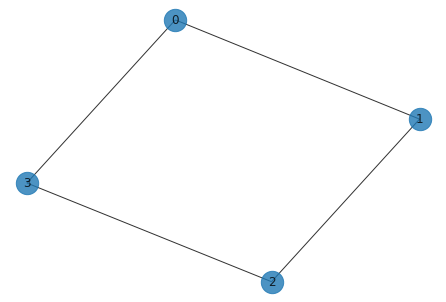

In [488]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
# G.add_edges_from([(0, 1), (0, 2), (1, 2), (2, 3)])
# G.add_nodes_from([0, 1, 2, 3, 4])
# G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (1,4), (3,4)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

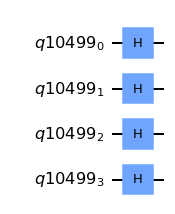

In [489]:
from qiskit import QuantumCircuit, QuantumRegister, execute, Aer, transpile
from qiskit.visualization import plot_histogram
from qiskit.compiler import assemble

from scipy.optimize import minimize

%matplotlib inline

n_qb = 4
qubit = QuantumRegister(n_qb)

qc = QuantumCircuit(qubit)
qc.h(qubit)

qc.draw('mpl')

### 3.2 Cost function and Phase operators

The goal is to minimize the cost function C. Since we are working on (n_qb) states, each state produces either 1 or 0 value for C. So, minimization of the expectation value of C is the objective. For such aim, the phase operators can be planted in the circuit.

$U(C, \gamma) = \exp{(-i\gamma C)}$

Where, $C = \frac{1}{2}\left(1 - \sigma^z_i\sigma^z_j\right)$ for $i^{th}$ and $j^{th}$ string in $z \in \{0,1\}^n$. It's the correct time to remember the QUBO model.

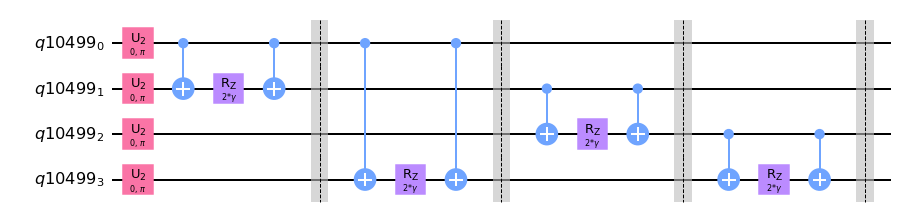

In [490]:
from qiskit.circuit import Parameter

gamma = Parameter("$\\gamma$")
for pair in list(G.edges()):
    qc.rzz(2 * gamma, pair[0], pair[1])
    qc.barrier()

qc.decompose().draw('mpl')

### 3.3 Mixing Operator

This implementation can be taken as a Parameterized Quantum Circuit (PQC). The spherical angle ($\theta$) is a tunnable parameter. The mixing operator, along with the phase operator, transforms the initial state. The cost function takes different value with every such transformation and classical optimizer works in our best of interest.

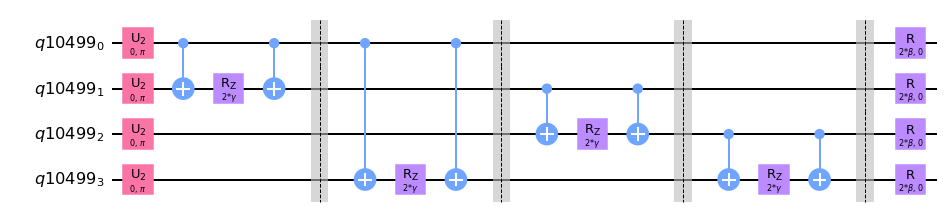

In [491]:
beta = Parameter("$\\beta$")
for i in range(0, n_qb):
    qc.rx(2 * beta, i)
    
qc.decompose().draw('mpl')

### 3.4 Classical Optimizer

From the Fig 2. it's clear that the job for the optimizer is to check for the minimum expectation value of the cost function. At the end of every execution, it will prescribe a new set of parameters $(\phi, \theta)$. This new parameters in turn will be fed into the "PQC" for next iteration of cost function. And it's basically rinse and repeat untill the minimum value of the cost function is obtained.

Classical Machine Learning models have myriad of optimizer. However, by far the most popular is "Adam" optimizer. For this particular task, I won't go with it and rather choose "COBLYA" optimizer. It is a numerical optimization method for constrained problems where the derivative of the objective function is not known. The reason to choose it over "Adam" is pretty much self-explanatory now, isn't it? 

It's easy to see the cost function $C$ is determined by two adjacent vertices (say $i^{th}$ and $j^{th}$). The cut will split the vertices into two sets and likewise the edges. If both are in same set, i.e., when the $i^{th}$ and $j^{th}$ indices in a bit string $z$, denoted as $z_i$ and $z_j$ are equal bits then $C_{z_i,z_j}$ bears 0 or else 1. So a simpler way to put the cost function will be as follows. 

$C_{i,j}(z) = (1- \delta_{z_iz_j})$, where, $\delta_{z_iz_j}$ is the Kronecker delta function.

<b>For a better understanding of this simplified form of "Cost function" visit page 43 and page 44 in the reference [8].</b>

The cost function value will be sum amongst all the adjacent vertices indexed by $\{i, j\}$. The expectation value will be amongst all the bit string in the set $\{0,1\}^n$.

In [492]:
from qiskit.compiler import assemble
import sys
def expectation(theta):
    cost = 0
    cummulative = 0
    sum_count = 0

    backend = Aer.get_backend('qasm_simulator')
    pqc = create_qaoa_circ(theta)
    result = execute(pqc, backend, shots=1024).result().get_counts()

    for bitstring, count in result.items():
        for i, j in G.edges():
            if bitstring[i] != bitstring[j]:
                cost -= 1
        cummulative += cost * count
        sum_count += count

    return cummulative/sum_count

The above code snippet provides the expectation value, $\langle C\rangle$. The function takes in one argument, $\theta$, which the mixing parameter. Moreover, there's a PQC generated by the function "create_qaoa_circ". I have built the parameterized circuit all along this notebook, however, it can only be measured once before it is lost for forever, rendering it good for nothing. During the optimization, the PQC will be tortured by measurement at the end of every iteration. Hence, the PQC should be wrapped around by a function, such that, its return value is the PQC. The qiskit has provided the code snippet [9]. I took the comfort to copy the code snippet and tune it upto my terms.

In [493]:
def create_qaoa_circ(theta):
    n_qb = len(G.nodes())
    qc_qaoa = QuantumCircuit(n_qb)

    # initial_state
    for i in range(0, n_qb):
        qc_qaoa.h(i)

    for irep in range(0, len(theta)):

        # problem unitary
        for pair in list(G.edges()):
            qc_qaoa.rzz(2 * theta[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, n_qb):
            qc_qaoa.rx(2 * theta[irep], i)

    qc_qaoa.measure_all()

    return qc_qaoa

### 3.5 Run the circuit

It's now time to bring the hard work in to fruition. Let's run the circuit and see for the results. There must be two quantum states which minimizes the cost function, $|0101\rangle$ and $|1010\rangle$. The minimization function is provided by python scientific library "SciPy". The documentation is quite easy to understand, visit it from [SciPy documentation for minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

In [494]:
from numpy import pi
res = minimize(lambda x: expectation(x), [1., 1., 1., 1.], method='COBYLA')
print (res)

     fun: -17.40234375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 43
  status: 1
 success: True
       x: array([0.96272424, 2.03766438, 1.0221012 , 0.94175917])


### 3.6 Results
The reults are in and there's the long awaited good news. The states have been optimized to achceive the minimum value for $\langle C \rangle$. The printed value "x" shows the first four optimized values for $\beta$ and the last four for $\gamma$. These values can be used to feed the PQC and visualize the simulation of the state. That should be the last brick to lay down, at least for the case of Max-Cut. Let me reiterate that the staes that minimizes $\langle C \rangle$ are $|0101\rangle$ and $|1010\rangle$, so the highest counts for theses two states must be evident below.

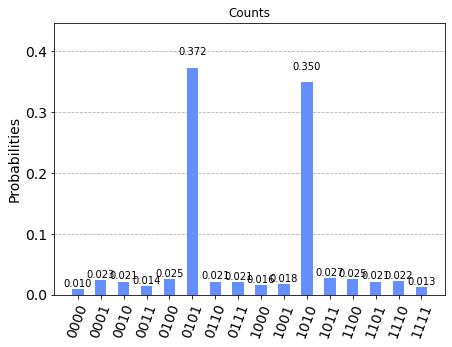

In [495]:
simulator = Aer.get_backend('qasm_simulator')
c = transpile(create_qaoa_circ(res.x), simulator)

my_qobj = assemble(c)
result = simulator.run(my_qobj).result()

plot_histogram(result.get_counts(), title='Counts')

## References

1. Bharti, K., Cervera-Lierta, A., Kyaw, T. H., Haug, T., Alperin-Lea, S., Anand, A., ... & Aspuru-Guzik, A. (2021). Noisy intermediate-scale quantum (NISQ) algorithms. arXiv preprint arXiv:2101.08448.
<br></br>
2. Farhi, E., Goldstone, J., & Gutmann, S. (2014). A quantum approximate optimization algorithm. arXiv preprint arXiv:1411.4028.
<br></br>
3. Farhi, E., & Harrow, A. W. (2016). Quantum supremacy through the quantum approximate optimization algorithm. arXiv preprint arXiv:1602.07674.
Chicago	
<br></br>
4. Cerezo, M., Arrasmith, A., Babbush, R., Benjamin, S. C., Endo, S., Fujii, K., ... & Coles, P. J. (2021). Variational quantum algorithms. Nature Reviews Physics, 1-20.
Chicago	
<br></br>
5. Glover, F., Kochenberger, G., & Du, Y. (2019). Quantum Bridge Analytics I: a tutorial on formulating and using QUBO models. 4OR, 17(4), 335-371.
<br></br>
6. Choi, J., & Kim, J. (2019, October). A tutorial on quantum approximate optimization algorithm (qaoa): Fundamentals and applications. In 2019 International Conference on Information and Communication Technology Convergence (ICTC) (pp. 138-142). IEEE.
<br></br>
7. Wang, Q., & Abdullah, T. (2018). An introduction to quantum optimization approximation algorithm. 
<br></br>
8. Guerrero, N., 2020. Solving Combinatorial Optimization Problems using the Quantum Approximation Optimization Algorithm. [online] Scholar.afit.edu. Available at: <https://scholar.afit.edu/cgi/viewcontent.cgi?article=4264&context=etd>.
<br></br>
9. Qiskit.org. n.d. Solving combinatorial optimization problems using QAOA. [online] Available at: <https://qiskit.org/textbook/ch-applications/qaoa.html> [Accessed 16 September 2021].